Training Time       : 16.392 sec
Final Training Loss : 0.156083
Final Validation Loss: 0.179590
--------------------------------------
Accuracy            : 0.7143
Precision           : 0.6786
Recall              : 0.3519
F1 Score            : 0.4634


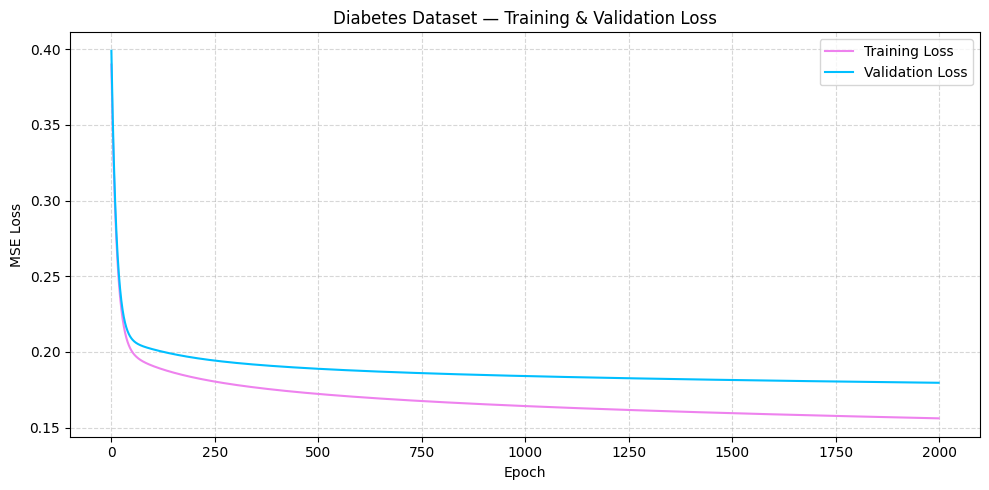

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt



# Load and Prepare Dataset

DATA_URL = (
    "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/"
    "f5ad98739198799d64a8f9ded959c65de50f4f76/Dataset/diabetes.csv"
)

df = pd.read_csv(DATA_URL)

X = df.drop("Outcome", axis=1).astype(np.float32).values
y = df["Outcome"].astype(np.float32).values.reshape(-1, 1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train / test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors
train_X = torch.tensor(X_train, dtype=torch.float32)
test_X  = torch.tensor(X_test,  dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_y  = torch.tensor(y_test,  dtype=torch.float32)



# Define Neural Network (different layout, same math)

class DiabetesFFN(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.act = nn.ReLU()
        self.layer1 = nn.Linear(n_inputs, 40)
        self.layer2 = nn.LazyLinear(1000)
        self.output  = nn.LazyLinear(1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        return self.output(x)


# Hyperparameters
EPOCHS = 2000
LR = 1e-3

model = DiabetesFFN(train_X.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LR)



# Training Loop

train_curve = []
valid_curve = []

tic = time.time()

for ep in range(EPOCHS):

    # Forward pass
    preds = model(train_X)
    loss  = loss_fn(preds, train_y)

    # Record training loss
    train_curve.append(loss.item())

    # Validation loss (no grad)
    with torch.no_grad():
        val_loss = loss_fn(model(test_X), test_y).item()
        valid_curve.append(val_loss)

    # Gradient update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

toc = time.time()



# Predict → Scale → Round  (same behavior)

with torch.no_grad():
    raw_test_output = model(test_X).numpy()

scaled = MinMaxScaler().fit_transform(raw_test_output)
rounded_preds = torch.round(torch.tensor(scaled)).numpy()

true_vals = y_test



# Metrics

acc = accuracy_score(true_vals, rounded_preds)
prec = precision_score(true_vals, rounded_preds, zero_division=0)
rec  = recall_score(true_vals, rounded_preds, zero_division=0)
f1   = f1_score(true_vals, rounded_preds, zero_division=0)

print(f"Training Time       : {toc - tic:.3f} sec")
print(f"Final Training Loss : {train_curve[-1]:.6f}")
print(f"Final Validation Loss: {valid_curve[-1]:.6f}")
print("--------------------------------------")
print(f"Accuracy            : {acc:.4f}")
print(f"Precision           : {prec:.4f}")
print(f"Recall              : {rec:.4f}")
print(f"F1 Score            : {f1:.4f}")



# Plot Training / Validation Loss

plt.figure(figsize=(10, 5))
plt.plot(train_curve, color="violet", label="Training Loss", linewidth=1.5)
plt.plot(valid_curve, color="Orange", label="Validation Loss", linewidth=1.5)
plt.title("Diabetes Dataset — Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Training Time: 8.195517301559448
Final Train Loss: 0.05799689516425133
Final Validation Loss: 0.07199500501155853
Accuracy: 0.956140350877193
Precision: 0.9466666666666667
Recall: 0.9861111111111112
F1 Score: 0.9659863945578231


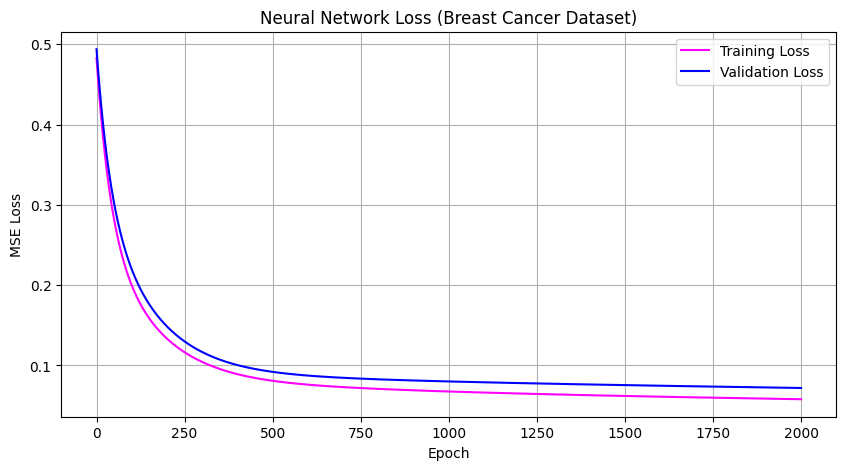


=== Logistic Regression Performance ===
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1: 0.9861111111111112

=== SVM Performance (RBF Kernel) ===
Accuracy: 0.9824561403508771
Precision: 0.9861111111111112
Recall: 0.9861111111111112
F1: 0.9861111111111112


In [12]:

# Fully Connected Neural Network on Breast Cancer Dataset

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time



# Load cancer dataset

cancer = datasets.load_breast_cancer()
X = cancer.data.astype(np.float32)
y = cancer.target.astype(np.float32).reshape(-1,1)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.float32)



# Neural Network Architecture

class CancerNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 48),
            nn.ReLU(),
            nn.Linear(48, 256),     # BIG hidden layer
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.layers(x)


model = CancerNet(X_train.shape[1])

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)



# Training Loop

epochs = 2000
training_loss = []
validation_loss = []

start = time.time()

for ep in range(epochs):

    # Forward pass
    predictions = model(X_train_t)
    loss = criterion(predictions, y_train_t)

    # Record loss values
    training_loss.append(loss.item())
    validation_loss.append(criterion(model(X_val_t), y_val_t).item())

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

end = time.time()
train_time = end - start



# Convert raw outputs

with torch.no_grad():
    raw_scores = model(X_val_t).numpy()

scaled_scores = MinMaxScaler().fit_transform(raw_scores)
rounded_preds = np.round(scaled_scores)



# Performance Metrics

acc  = accuracy_score(y_val, rounded_preds)
prec = precision_score(y_val, rounded_preds)
rec  = recall_score(y_val, rounded_preds)
f1   = f1_score(y_val, rounded_preds)

print("Training Time:", train_time)
print("Final Train Loss:", training_loss[-1])
print("Final Validation Loss:", validation_loss[-1])
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)



# Plot Training vs Validation Loss

plt.figure(figsize=(10,5))
plt.plot(training_loss, label="Training Loss", color="magenta")
plt.plot(validation_loss, label="Validation Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Neural Network Loss (Breast Cancer Dataset)")
plt.grid(True)
plt.legend()
plt.show()



# Logistic Regression Comparison

log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train.ravel())
log_preds = log_reg.predict(X_val)

log_acc = accuracy_score(y_val, log_preds)
log_prec = precision_score(y_val, log_preds)
log_rec = recall_score(y_val, log_preds)
log_f1 = f1_score(y_val, log_preds)

print("\n Logistic Regression Performance ")
print("Accuracy:", log_acc)
print("Precision:", log_prec)
print("Recall:", log_rec)
print("F1:", log_f1)



# SVM Comparison

svm = SVC(kernel="rbf", C=2.0, gamma="scale")
svm.fit(X_train, y_train.ravel())
svm_preds = svm.predict(X_val)

svm_acc = accuracy_score(y_val, svm_preds)
svm_prec = precision_score(y_val, svm_preds)
svm_rec = recall_score(y_val, svm_preds)
svm_f1 = f1_score(y_val, svm_preds)

print("\n SVM Performance ")
print("Accuracy:", svm_acc)
print("Precision:", svm_prec)
print("Recall:", svm_rec)
print("F1:", svm_f1)


In [17]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data normalization using TRAIN statistics only

root = "../"

raw_train = datasets.CIFAR10(root, train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img for img, _ in raw_train], dim=0)

mean = imgs.mean(dim=[0,2,3])
std = imgs.std(dim=[0,2,3])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_data = datasets.CIFAR10(root, train=True, download=False, transform=transform)
test_data  = datasets.CIFAR10(root, train=False, download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)


# Fully-connected network (1 hidden layer, 512 units)

class CIFARNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*32*32, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFARNet().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=5e-4
)


# Training

epochs = 300
start_time = time.time()

train_loss_history = []
val_acc_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss_history.append(total_loss / len(train_loader))

    # Validation accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss={train_loss_history[-1]:.4f} | Val Acc={val_acc*100:.2f}%")

end_time = time.time()

print(f"\nTraining time: {end_time - start_time:.2f} seconds")


Epoch 1/300 | Loss=1.6562 | Val Acc=45.96%
Epoch 2/300 | Loss=1.4522 | Val Acc=49.08%
Epoch 3/300 | Loss=1.3634 | Val Acc=49.98%
Epoch 4/300 | Loss=1.2983 | Val Acc=50.26%
Epoch 5/300 | Loss=1.2343 | Val Acc=51.13%
Epoch 6/300 | Loss=1.1899 | Val Acc=51.96%
Epoch 7/300 | Loss=1.1582 | Val Acc=50.85%
Epoch 8/300 | Loss=1.1053 | Val Acc=51.76%
Epoch 9/300 | Loss=1.0679 | Val Acc=52.21%
Epoch 10/300 | Loss=1.0237 | Val Acc=50.69%
Epoch 11/300 | Loss=1.0018 | Val Acc=51.49%
Epoch 12/300 | Loss=0.9635 | Val Acc=52.00%
Epoch 13/300 | Loss=0.9328 | Val Acc=50.97%
Epoch 14/300 | Loss=0.9026 | Val Acc=51.87%


KeyboardInterrupt: 

In [ ]:

# CIFAR-10 Fully Connected Network (

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt


# Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Dataset + Normalization

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

train_set = datasets.CIFAR10(root="../", train=True, download=True, transform=transform)
val_set   = datasets.CIFAR10(root="../", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)


# Improved Fully Connected MLP for CIFAR-10

class MLP_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3072, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.4),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

model = MLP_CIFAR10().to(device)


# Loss + Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Training Loop — 300 epochs

epochs = 300
train_loss_hist = []
val_acc_hist = []
start = time.time()

for epoch in range(1, epochs + 1):
    # Train
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)
    train_loss_hist.append(avg_train_loss)

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            _, pred = torch.max(out, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

end = time.time()
print("\nTotal training time:", end - start, "seconds")


# Plot

plt.figure(figsize=(10,4))
plt.plot(train_loss_hist, label="Training Loss", color="magenta")
plt.plot(val_acc_hist, label="Validation Accuracy", color="blue")
plt.legend()
plt.title("Fully Connected CIFAR-10 MLP Training (300 epochs)")
plt.xlabel("Epoch")
plt.grid(True)
plt.show()


Using device: cpu
Epoch   1 | Train Loss: 1.7418 | Val Acc: 0.4579
Epoch   2 | Train Loss: 1.5422 | Val Acc: 0.4921
Epoch   3 | Train Loss: 1.4503 | Val Acc: 0.4993
Epoch   4 | Train Loss: 1.3823 | Val Acc: 0.5183
Epoch   5 | Train Loss: 1.3278 | Val Acc: 0.5236
Epoch   6 | Train Loss: 1.2805 | Val Acc: 0.5334
Epoch   7 | Train Loss: 1.2422 | Val Acc: 0.5483
Epoch   8 | Train Loss: 1.1941 | Val Acc: 0.5583
Epoch   9 | Train Loss: 1.1641 | Val Acc: 0.5475
Epoch  10 | Train Loss: 1.1343 | Val Acc: 0.5555
Epoch  11 | Train Loss: 1.0985 | Val Acc: 0.5641
Epoch  12 | Train Loss: 1.0715 | Val Acc: 0.5629
Epoch  13 | Train Loss: 1.0348 | Val Acc: 0.5759
Epoch  14 | Train Loss: 1.0052 | Val Acc: 0.5683
Epoch  15 | Train Loss: 0.9812 | Val Acc: 0.5682
Epoch  16 | Train Loss: 0.9524 | Val Acc: 0.5727
Epoch  17 | Train Loss: 0.9342 | Val Acc: 0.5758
Epoch  18 | Train Loss: 0.9023 | Val Acc: 0.5810
Epoch  19 | Train Loss: 0.8859 | Val Acc: 0.5807
Epoch  20 | Train Loss: 0.8612 | Val Acc: 0.5792
Ep